In [1]:
using JuMP, Gurobi
using DataFrames, CSV, Combinatorics
using Random
using LinearAlgebra
using Distances
using Plots, StatsPlots
using Suppressor
using Pkg
Pkg.add("StatsPlots")
Pkg.add("Random")
Pkg.add("Combinatorics")
Pkg.add("Distances")
Pkg.add("Suppressor")
area = CSV.read("Pb1_areas.csv", DataFrame);
shelter = CSV.read("Pb1_shelters.csv", DataFrame);

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
area = Matrix(area)
shelter = Matrix(shelter); 
# assumed variable
I = size(area, 1)
J = size(shelter, 1)

# demand
pop = area[:,3]
totpop = sum(area[:,3])

# supply
capa = shelter[:, 3]

# supply-demand
dist = zeros(I,J);
for i = 1:I, j = 1:J
    dist[i,j] =  abs(area[i,1]-shelter[j,1]) +  abs(area[i,2]-shelter[j,2])
end

In [3]:
function emergency_resp1(dist::Matrix{Float64}, pop::Vector{Float64}, capa::Vector{Float64})
        
    # Definition of model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 60); # role?
    
    # Main variable
    @variable(model, r[1:I, 1:J] >=0, Int);
    @variable(model, b[1:J], Bin);
    
    # Objective: minimizing the total cost (distance) of the tour
    @objective(
        model, 
        Min,
        sum(
            dist[i,j] * r[i,j]
            for i in 1:I,
                j in 1:J
        )
    )
    
    # SHARED CONSTRAINTS
    @constraint(
        model, 
        assign_if_built[j in 1:J],  # forall
        sum(
            r[i,j] 
            for i in 1:I 
            ) 
            <= capa[j] * b[j]
    ); 

    @constraint(
        model, 
        home_forall_resident[i in 1:I],
        sum(
            r[i,j] 
            for j in 1:J
            ) == pop[i]
    );
    
    @constraint(model, 
        shelter10,
        sum(
            b[j] 
            for j in 1:J
         ) <= 10
    );
    optimize!(model)
    return model, objective_value(model), r, b
end

emergency_resp1 (generic function with 1 method)

In [4]:
function emergency_resp2(dist::Matrix{Float64}, pop::Vector{Float64}, capa::Vector{Float64})
    # Definition of model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 60);

    # variable
    @variable(model, r[1:I, 1:J], Bin);
    @variable(model, b[1:J], Bin);

    # Objective: minimizing the total cost (distance) of the tour
    @objective(
        model, 
        Min,
        sum(
            dist[i,j] * r[i,j] * pop[i]
            for i in 1:I,
                j in 1:J
        )
    );

    @constraint(
        model,
        supply_atmost10,
        sum(b[j] for j in 1:J) <= 10
    );
    @constraint(
        model, 
        supply_ifbuilt_twostone[j in 1:J],
        sum(pop[i] * r[i,j] for i in 1:I) <= capa[j] * b[j]
    );

    
    # 1 (sum) + J (ineq) + I (equal) = 1 + 55 + 200 
    @constraint(
        model, 
        demand_area_partition[i in 1:I],
        sum(r[i,j] for  j in 1:J) == 1
    );

    optimize!(model)
    return model, objective_value(model), r, b
end

emergency_resp2 (generic function with 1 method)

In [5]:
function emergency_resp3(dist::Matrix{Float64}, pop::Vector{Float64}, capa::Vector{Float64})
    # Definition of model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 60);

    # variable
    @variable(model, M >= 0, Int);
    @variable(model, r[1:I, 1:J], Bin);
    @variable(model, b[1:J], Bin);

    # Objective: minimizing the total cost (distance) of the tour
    @objective(
        model, 
        Min,
        M
    );

    @constraint(model, 
        supply_ifbuilt_twostone[j in 1:J],
        sum(r[i,j] * pop[i] for i in 1:I) <= capa[j] * b[j]
    );

    @constraint(
        model, 
        demand_area_partition[i in 1:I],
        sum(r[i,j] for j in 1:J) == 1
    );

    # supply
    @constraint(model, 
        supply_atmost10,
        sum(b[j] for j in 1:J) <= 10
    );

    @constraint(model, 
        max_of_minmax[i in 1:I, j in 1:J],
            dist[i,j] * r[i,j] <= M
    );

    optimize!(model)
    return model, objective_value(model), r, b
end

emergency_resp3 (generic function with 1 method)

In [6]:
model1, y1, r1, b1 = emergency_resp1(dist, pop, capa)
model2, y2, r2, b2 = emergency_resp2(dist, pop, capa)
model3, y3, r3, b3 = emergency_resp3(dist, pop, capa)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-11
Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 256 rows, 11055 columns and 22110 nonzeros
Model fingerprint: 0xc66661a5
Variable types: 0 continuous, 11055 integer (55 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [5e-03, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 6e+02]
Found heuristic solution: objective 771307.68845
Presolve time: 0.01s
Presolved: 256 rows, 11055 columns, 22110 nonzeros
Variable types: 0 continuous, 11055 integer (55 binary)
Found heuristic solution: objective 770422.28682

Root relaxation: objective 8.992164e+04, 251 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective 

(A JuMP Model
Minimization problem with:
Variables: 11056
Objective function type: VariableRef
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 200 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 11056 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.Integer`: 1 constraint
`VariableRef`-in-`MathOptInterface.ZeroOne`: 11055 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: M, b, demand_area_partition, max_of_minmax, r, supply_atmost10, supply_ifbuilt_twostone, 5.0, VariableRef[r[1,1] r[1,2] … r[1,54] r[1,55]; r[2,1] r[2,2] … r[2,54] r[2,55]; … ; r[199,1] r[199,2] … r[199,54] r[199,55]; r[200,1] r[200,2] … r[200,54] r[200,55]], VariableRef[b[1], b[2], b[3], b[4], b[5], b[6], b[7], b[8], b[9], b[10]  …  b[46], b[47], b[48], b[49], b[50], b[51], b[52], b[53], b[54], b[55]])

In [7]:
println(y1/totpop)
println(y2/totpop)

2.146453748932697
2.1465892996169176


In [35]:
function distplot_1(dist::Matrix, r::Matrix)
    res_dist = []
    for i in 1:I, j in 1:J
        if dist[i,j] * value(r[i,j]) > .1
            push!(res_dist, dist[i,j])
        end
    end
    return res_dist
end

function distplot(dist::Matrix, r::Matrix)
    res_dist = []
    for i in 1:I, j in 1:J
        if dist[i,j] * value(r[i,j]) > .1
            push!(res_dist, dist[i,j] * value(r[i,j]))
        end
    end
    return res_dist
end

res_dist1 = distplot_1(dist, r1);
res_dist2 = distplot(dist, r2);
res_dist3 = distplot(dist, r3);

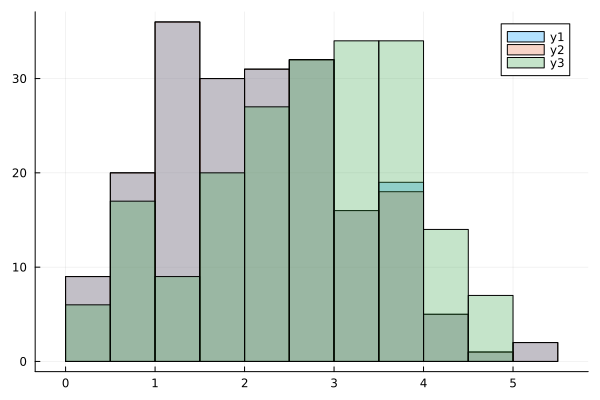

In [34]:
histogram([res_dist1, res_dist2, res_dist3], fillalpha=0.3)